In [4]:
using Pkg, Revise
Pkg.activate(".")

  Activating environment at `~/Desktop/SelectivelyAdaptiveLasso/Project.toml`


In [2]:
using CSV, DataFrames, VegaLite
import Statistics: mean

In [3]:
data = CSV.read(open("/Users/aschuler/Downloads/winequality-red.csv"), DataFrame, copycols=true)
Y = float(data.quality)
Y = Y .- mean(Y)
X = Matrix(data[:,[var for var in names(data) if var ≠ "quality"]]);

n_val = Int(round(length(Y)/2))
X_val, Y_val = X[1:n_val,:], Y[1:n_val]
X, Y = X[(n_val+1):end,:], Y[(n_val+1):end];

In [4]:
# import Distributions as Dist
# import LinearAlgebra: diagm

# n, p = 5000, 10

# X_dist = Dist.reshape(
#     Dist.MvNormal(zeros(p), 0.1ones(p,p) + 0.9diagm(ones(p))), 
#     (1,p)
# )
# ϵ_dist = Dist.Normal(0,1)

# X = vcat(rand(X_dist, n)...)
# ϵ = rand(ϵ_dist, n)

# Y = 5X[:,1] + X[:,2].^2 - 3X[:,3].*X[:,4] + ϵ
# Y = Y .- mean(Y)

# n_val = Int(round(n/2))
# X_val, Y_val = X[1:n_val,:], Y[1:n_val]
# X, Y = X[(n_val+1):end,:], Y[(n_val+1):end];

# xgboost

In [5]:
using XGBoost

In [6]:
B = 501
@time bst = xgboost(X, B, label = Y, eta = 0.01, max_depth = 3);

[1]	train-rmse:0.928552
[2]	train-rmse:0.924153
[3]	train-rmse:0.919854
[4]	train-rmse:0.915585
[5]	train-rmse:0.911371
[6]	train-rmse:0.907255
[7]	train-rmse:0.903193
[8]	train-rmse:0.899157
[9]	train-rmse:0.894977
[10]	train-rmse:0.891051
[11]	train-rmse:0.886982
[12]	train-rmse:0.883125
[13]	train-rmse:0.879164
[14]	train-rmse:0.875470
[15]	train-rmse:0.871611
[16]	train-rmse:0.867981
[17]	train-rmse:0.864223
[18]	train-rmse:0.860653
[19]	train-rmse:0.856994
[20]	train-rmse:0.853527
[21]	train-rmse:0.850103
[22]	train-rmse:0.846583
[23]	train-rmse:0.843263
[24]	train-rmse:0.839757
[25]	train-rmse:0.836425
[26]	train-rmse:0.833088
[27]	train-rmse:0.829929
[28]	train-rmse:0.826584
[29]	train-rmse:0.823502
[30]	train-rmse:0.820265
[31]	train-rmse:0.817122
[32]	train-rmse:0.814162
[33]	train-rmse:0.811053
[34]	train-rmse:0.808179
[35]	train-rmse:0.805193
[36]	train-rmse:0.802299
[37]	train-rmse:0.799537
[38]	train-rmse:0.796605
[39]	train-rmse:0.793749
[40]	train-rmse:0.791065
[41]	trai

  0.815120 seconds (1.43 M allocations: 83.886 MiB, 1.65% gc time, 63.36% compilation time)


In [7]:
ntrees = 1:B # 1:100:B
bst_val_loss = map(ntrees) do ntree
    Ŷ = predict(bst, X_val, ntree_limit=ntree)
    mean((Y_val - Ŷ).^2)
end;

In [8]:
df_xgb = DataFrame(
    n_iter = ntrees,
    loss = bst_val_loss,
    learner = "XGBoost",
);

In [9]:
findmin(bst_val_loss)

(0.401185902518711, 309)

# SAL

In [31]:
import SelectivelyAdaptiveLasso as SAL
import StatsBase: sample

In [42]:
sal_spec = SAL.SALSpec(
    max_iter=1000,
    λ = 0.005,
    bases_per_iter=1,
    m_subsample=10,
    n_subsample=400,
    tol = 1e-3,
)
shuffle = sample(1:n_val, n_val, replace=false)
@time sal_fit, log = SAL.fit(
    sal_spec, 
    X, Y, 
    X_val=X_val[shuffle,:], Y_val=Y_val[shuffle],
    verbose=true, print_iter=50,
)
loss, loss_val = log;

(0.7055302088138821, 0.6114386336526839)
(0.4988642625696083, 0.4909746155309575)
(0.49028610677644985, 0.47222200153919563)
(0.47769785602605447, 0.4573300355234578)
(0.4744588472889, 0.4512863295908432)
(0.4683591188456145, 0.4514263256218401)
(0.46169564709616306, 0.4393603301967419)
(0.4605348685155952, 0.4398892147968298)
(0.4584870882726862, 0.4372150140759557)
(0.4541068602959808, 0.43961681143168724)
(0.45327143731433267, 0.4382319759179812)
(0.45041471278809464, 0.43913362121732613)
(0.44989997509965185, 0.4399094808678784)
(0.45001829331622584, 0.43959615517679057)
(0.4498681247108349, 0.43861155804531565)
(0.44803795093573473, 0.43755670704358013)
(0.4472698879359043, 0.4372425986863183)
(0.4477012247797608, 0.43723810451999506)
(0.44769154229124103, 0.43718055402962946)
(0.4474634788703275, 0.43527414662908614)
(0.4474074106575039, 0.4366443497463562)
  1.601297 seconds (598.69 k allocations: 1.311 GiB, 13.03% gc time)


In [43]:
keys(sal_fit.β)

KeySet for a Dict{Set{CartesianIndex{2}}, Float64} with 34 entries. Keys:
  Set(CartesianIndex{2}[CartesianIndex(0, 0), CartesianIndex(2, 1), CartesianIn…
  Set(CartesianIndex{2}[CartesianIndex(0, 0), CartesianIndex(2, 10)])
  Set(CartesianIndex{2}[CartesianIndex(0, 0), CartesianIndex(2, 1), CartesianIn…
  Set(CartesianIndex{2}[CartesianIndex(0, 0), CartesianIndex(2, 11), CartesianI…
  Set(CartesianIndex{2}[CartesianIndex(0, 0), CartesianIndex(2, 4), CartesianIn…
  Set(CartesianIndex{2}[CartesianIndex(0, 0), CartesianIndex(2, 1), CartesianIn…
  Set(CartesianIndex{2}[CartesianIndex(0, 0), CartesianIndex(2, 11), CartesianI…
  Set(CartesianIndex{2}[CartesianIndex(0, 0), CartesianIndex(2, 1), CartesianIn…
  Set(CartesianIndex{2}[CartesianIndex(0, 0), CartesianIndex(2, 9), CartesianIn…
  Set(CartesianIndex{2}[CartesianIndex(0, 0), CartesianIndex(2, 4), CartesianIn…
  Set(CartesianIndex{2}[CartesianIndex(0, 0), CartesianIndex(2, 2), CartesianIn…
  Set(CartesianIndex{2}[CartesianIndex(0, 0), 

In [13]:
findmin(loss_val)

(0.41171625885177404, 382)

In [14]:
df_sal = DataFrame(
    n_iter = 1:length(loss_val),
    loss = loss_val,
    learner = "SAL"
);

# Plot

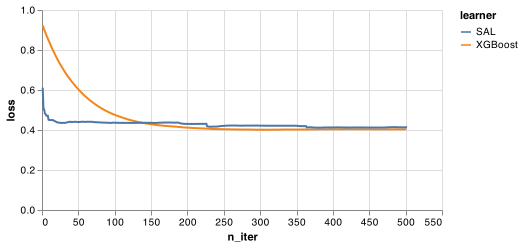

In [15]:
df = vcat(df_xgb, df_sal);
df |>
@vlplot(
    :line,
    x=:n_iter,
    y=:loss,
    color=:learner,
    width=400,
    height=200
)